In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import math
import itertools as it
from itertools import cycle
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from scipy import optimize

In [3]:
train = pd.read_csv('house_votes_84_train.csv')
X_tr=train.iloc[:,1:].values
y_tr=train.iloc[:,0].values
test = pd.read_csv('house_votes_84_test.csv')
X_te=test.iloc[:,1:].values
y_te=test.iloc[:,0].values

In [4]:
def trainH(X_tr,y_tr,d):
    n=X_tr.shape[0]
    m=X_tr.shape[1]
    h=0
    e=np.zeros(m)
    for i in range(0,m):
        for j in range(0,n):
            if X_tr[j][i]!=y_tr[j]:
                e[i]+=d[j]
    min=np.amin(e)
    for i in range(0,m):
        if e[i]==min:
            h=i
    return min,h

def updateD(d,a,x,y,h):
    n=d.shape[0]
    for i in range(0,n):
        if y[i]==x[i][h]:
            d[i]=d[i]*np.exp(-a)
        else:
            d[i]=d[i]*np.exp(a)
    d = d / np.linalg.norm(d,ord=1)
    sum=0
    for i in range(0,n):
        sum+=d[i]
    return d
    

def adaBoost_train(X_tr,y_tr,T):
    n=X_tr.shape[0]
    d=np.ones(n)
    d=d*1/n
    a=np.zeros(T)
    h=np.zeros((T,), dtype=np.int)
    for i in range(0,T):
        er,h[i]=trainH(X_tr,y_tr,d)
        a[i]=(1/2)*np.log((1-er)/er)
        d=updateD(d,a[i],X_tr,y_tr,h[i])
    return h,a

def adaBoost_test(X_te,h,a,T):  
    n=X_te.shape[0]
    y_predict=np.zeros((n,), dtype=np.int)
    for j in range(0,n):
        sum=0
        for i in range(0,T):
            temp=h[i]
            sum+=a[i]*X_te[j][temp]
        if sum>=0:
            y_predict[j]=1
        else:
            y_predict[j]=-1
    return y_predict

def adaBoost_evaluate(y_te,y_predict):
    n=y_te.shape[0]
    cnt=0
    for i in range(0,n):
        if y_te[i]==y_predict[i]:
            cnt+=1
    accuracy=cnt/n
    return accuracy
            

In [6]:
T=200
h,a=adaBoost_train(X_tr,y_tr,T)
y_predict_adaB=adaBoost_test(X_te,h,a,T)
accuracy_adaB=adaBoost_evaluate(y_te,y_predict_adaB)
print("adaBoost accuracy = %f" % accuracy_adaB)

adaBoost accuracy = 0.980000


In [7]:
def lossFunc(t):
    train = pd.read_csv('house_votes_84_train.csv')
    x=train.iloc[:,1:].values
    y=train.iloc[:,0].values
    n=y.shape[0]
    sum=0
    for i in range(0,n):
        sum+=np.log(1+np.exp(-y[i]*np.dot(t,x[i])))
    return sum

In [8]:
def LogisticRegression(t,x):
    n=x.shape[0]
    y_predict=np.zeros((n,), dtype=np.int)
    for i in range(0,n):
        p=1/(1+np.exp(-np.dot(t,x[i])))
        if p>0.5:
            y_predict[i]=1
        else:
            y_predict[i]=-1
    return y_predict

def LR_evaluate(y_te,y_predict):
    n=y_te.shape[0]
    cnt=0
    for i in range(0,n):
        if y_te[i]==y_predict[i]:
            cnt+=1
    accuracy=cnt/n
    return accuracy

In [9]:
n=X_tr.shape[1]
t_0=np.zeros(n)
min=optimize.fmin(lossFunc,t_0,maxiter=500)
y_predict_LR=LogisticRegression(min,X_te)
accuracy_LR=LR_evaluate(y_te,y_predict_LR)
print("Logistic Regression accuracy = %f" % accuracy_LR)

Logistic Regression accuracy = 0.920000


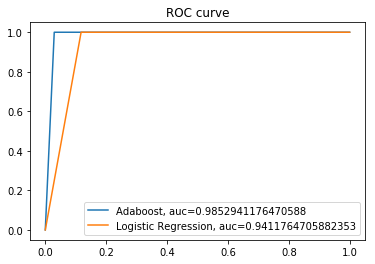

In [10]:
fpr, tpr, _ = metrics.roc_curve(y_te, y_predict_adaB)
auc = metrics.roc_auc_score(y_te, y_predict_adaB)
plt.plot(fpr,tpr,label="Adaboost, auc="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_te, y_predict_LR)
auc = metrics.roc_auc_score(y_te, y_predict_LR)
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(auc))

plt.legend(loc=4)
plt.title('ROC curve')
plt.show()

In [15]:
classifier = RandomForestClassifier(n_estimators=200, random_state=0)  
classifier.fit(X_tr, y_tr) 

# Calculate feature importances
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
print ("Coefficient of Logistic Regression: \n", min.reshape(4,4))
# Print the feature ranking
print("\nFeature ranking:")
for f in range(X_tr.shape[1]):
    n=indices[f]
    print("%d. %s_%d (%f)" % (f + 1, "bill", n+1, importances[indices[f]]))

Coefficient of Logistic Regression: 
 [[ 0.58441509  0.04176737 -0.17768556  0.57295138]
 [-0.04281271  0.25042777 -0.2994117  -0.19151863]
 [-0.72014161  0.14500613 -0.17457021  0.21958836]
 [ 0.44223912  0.19908995 -0.03687657 -0.65359931]]

Feature ranking:
1. bill_4 (0.356161)
2. bill_3 (0.117329)
3. bill_12 (0.104878)
4. bill_5 (0.099745)
5. bill_11 (0.056238)
6. bill_8 (0.047510)
7. bill_14 (0.044232)
8. bill_9 (0.037803)
9. bill_13 (0.026018)
10. bill_15 (0.022104)
11. bill_10 (0.017298)
12. bill_7 (0.017252)
13. bill_2 (0.016704)
14. bill_1 (0.014776)
15. bill_16 (0.011257)
16. bill_6 (0.010694)
